# Titanic with ensemble modeling

- **1.Introduction**
- **2.Load and check data**
- **3.Feature analysis**
- **4.Filling missing values**
- **5.Feature engineering**
- **6.Modeling**

## 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data


In [3]:
# Load data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [5]:
# Outlier detection

def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detect outliers from Age, sibsp, parch and fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

d:\anaconda\envs\machinelearning3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [7]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S


In [8]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set


In [9]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

d:\anaconda\envs\machinelearning3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### 2.4 check for null and missing values

In [12]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [13]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [14]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis

### 3.1 Numerical values


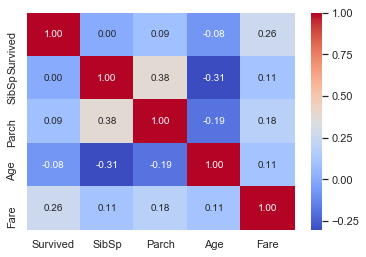

In [15]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

### SibSp

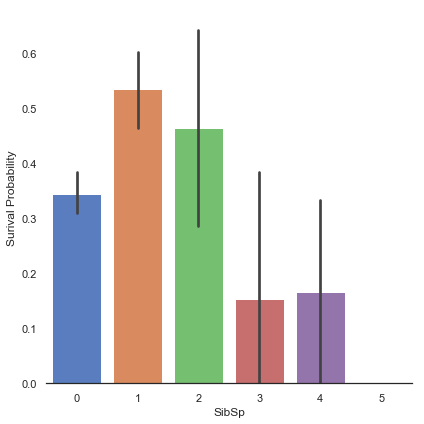

In [19]:
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Surival Probability")

### Parch


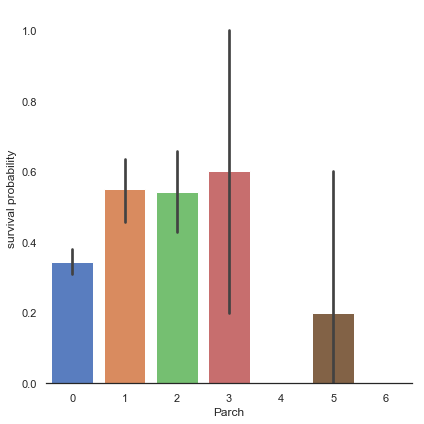

In [21]:
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Age


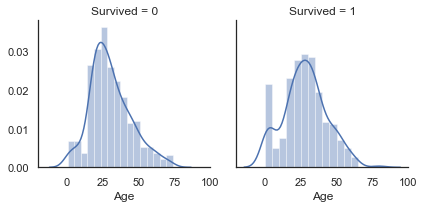

In [25]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

### Fare

In [26]:
dataset['Fare'].isnull().sum()

1

In [27]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

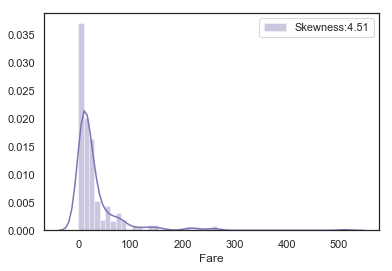

In [28]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness:%.2f' % dataset['Fare'].skew())
g = g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweigh very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [29]:
# apply log to fare to reduce skewness distribution.

dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

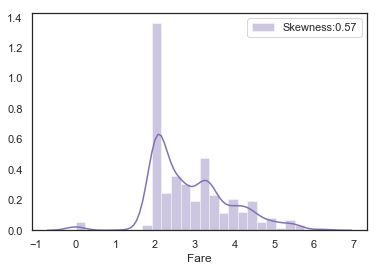

In [30]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness:%.2f' % dataset['Fare'].skew())
g = g.legend(loc='best')

Skewness is clearly reduced after the log transformation.

### 3.2 Categorical values

### Sex


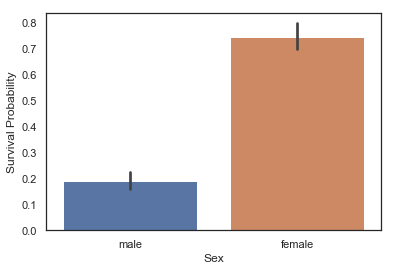

In [31]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probability")

In [33]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive that Female.
So, Sex, might play an important role in the prediction of the survival.

### Pclass

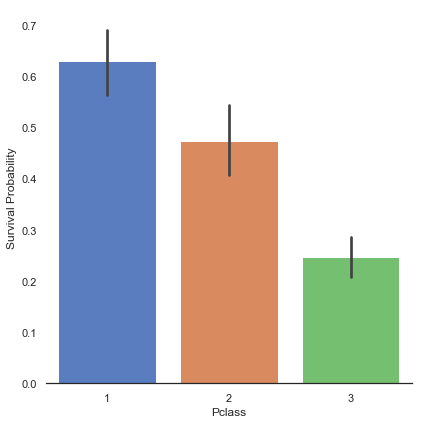

In [34]:
# Explore Pclass vs Survived

g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

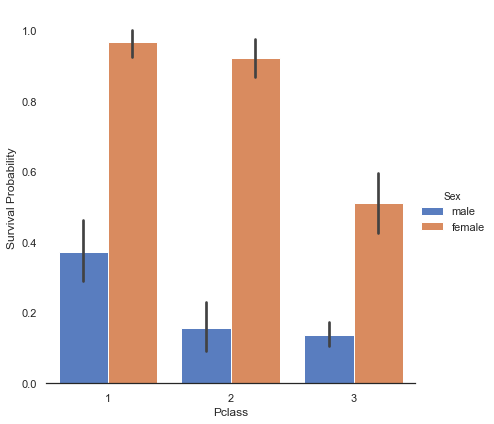

In [35]:
# Explore Pclass vs Survived by sex

g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passenger.

This trend is conserved when we look at both male and female passengers.

### Embarked

In [36]:
dataset['Embarked'].isnull().sum()

2

In [37]:
# Fill Embarked nan values of dataset with 's' most frequent value.
dataset['Embarked'] = dataset['Embarked'].fillna('S')

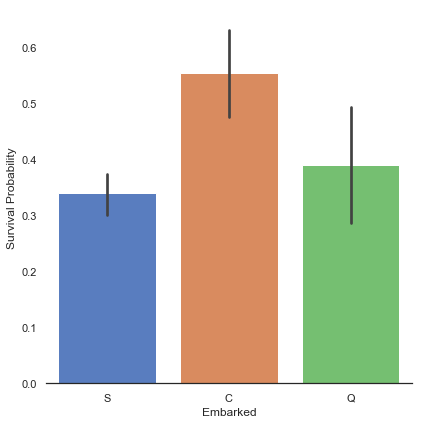

In [38]:
# Explore embarked vs survived
g = sns.catplot(x='Embarked', y='Survived', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

It seems that passenger coming from Cherbourg(C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherborg than Q, S.

Let's see the Pclass distribution vs Embarked.

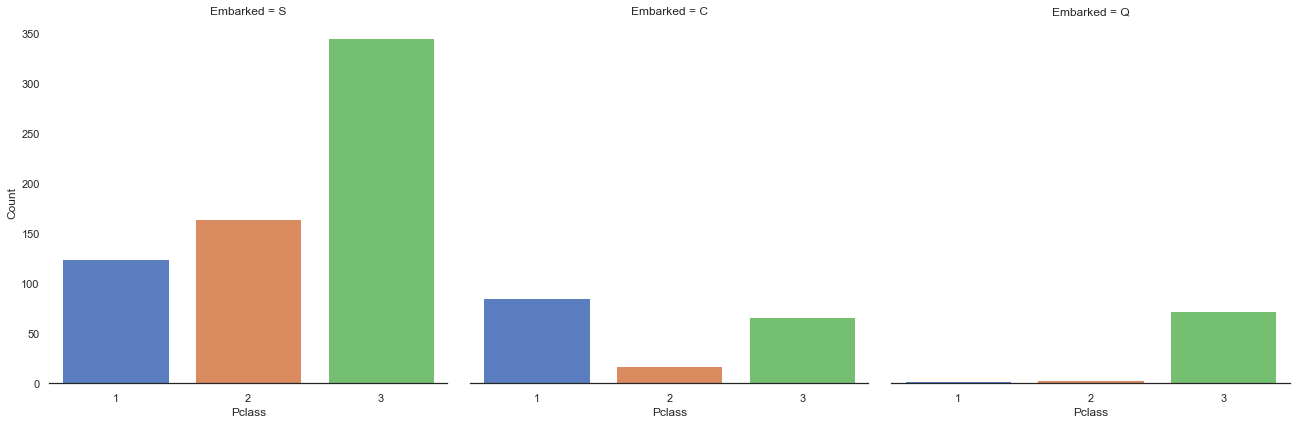

In [40]:
# Explore Pclass via Embarked

g = sns.catplot('Pclass', col='Embarked', data=train, height=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

Indeed, the third class is the most frequent for passenger coming from S and Q, whereas C passengers are mostly in first class which have the highest survival rate.

## 4. Filling missing values

### 4.1 Age
Since there is subpopulations that have more chance to survive, it is preferable to keep the age feature and to impute the missing values.

To adress this problem, I looked at the most correlated features with Age(Sex, Parch, Pclass and SibSP).

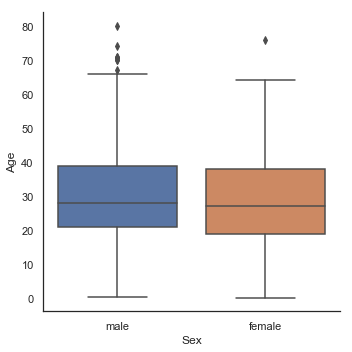

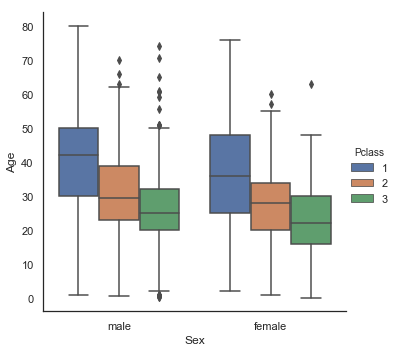

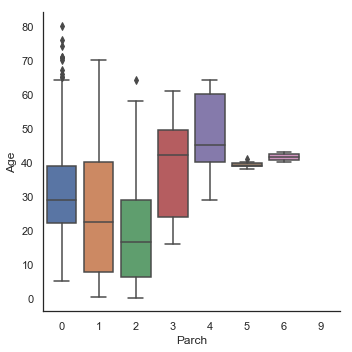

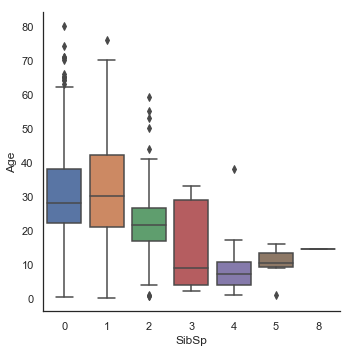

In [41]:
g = sns.catplot(x='Sex', y='Age', data=dataset, kind='box')
g = sns.catplot(x='Sex', y='Age', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(x='Parch', y='Age', data=dataset, kind='box')
g = sns.catplot(x='SibSp', y='Age', data=dataset, kind='box')

Age distribution seems to be the same in Male and Female subpopulations, So sex is not informative to predict Age.

However, first class passeners are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is.
The more a passenger has sibings/spouses the younger he is.

In [42]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

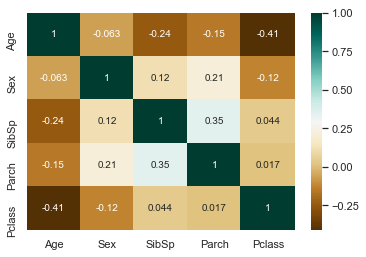

In [43]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

The correlation map confirms the factorplots observations except for Parch, Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents/children. But the general correlation is negative.

So I decided to use SibSp, Parch and Pclass in order to impute the missing ages.

The stragegy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [51]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][(dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
                             (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                             (dataset['Pclass'] == dataset.iloc[i]['Pclass'])].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

d:\anaconda\envs\machinelearning3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
d:\anaconda\envs\machinelearning3\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


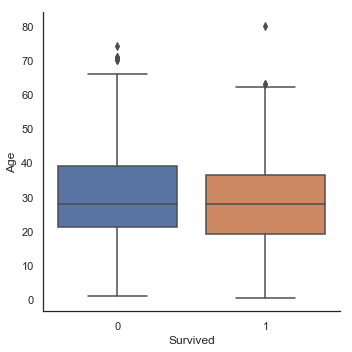

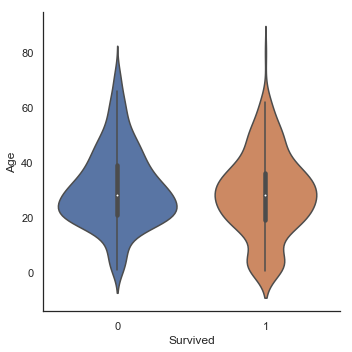

In [52]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

## 5. Feature engineering

### 5.1 Name/Title

In [53]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [54]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

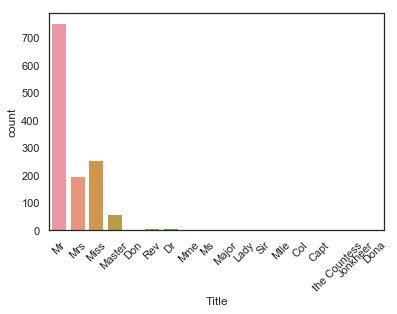

In [55]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

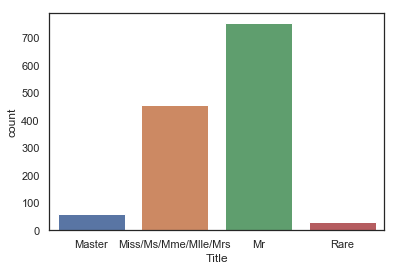

In [56]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

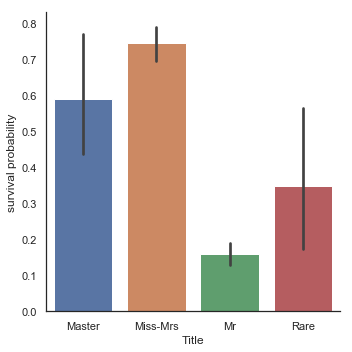

In [58]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Women and children first"

It is interesting to note that passengers with rare title have more chance to survive.

### 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, I choosed to create a 'Fize'(family size) feature which is the sum of SibSp, Parch and 1.

In [59]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

d:\anaconda\envs\machinelearning3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


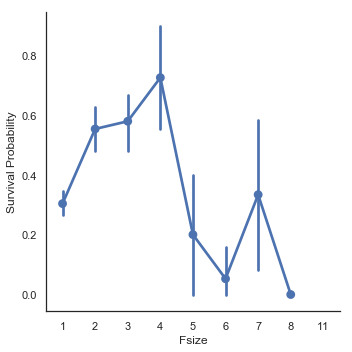

In [61]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

In [62]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

d:\anaconda\envs\machinelearning3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


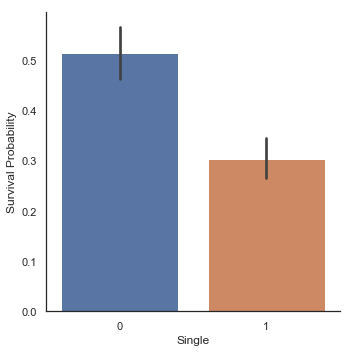

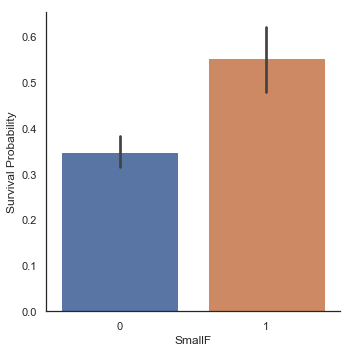

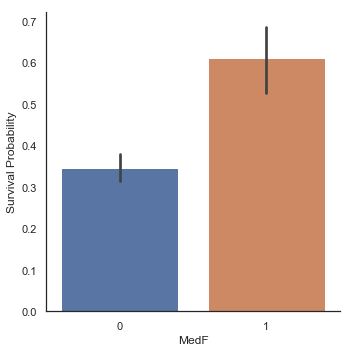

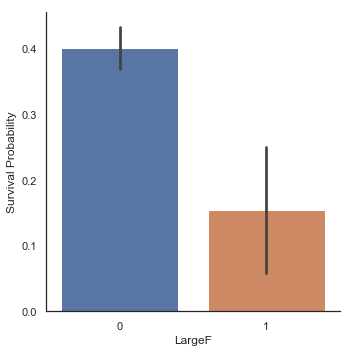

In [63]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [64]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [66]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

In [67]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1
